## Instructions 

After installing all the packages, restart the session and then continue with other cells (Run -> Restart and clear cell outputs)

In [ ]:
!pip install -U "tensorflow==2.15.*"

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.15.*"

In [ ]:
!pip install "tf-models-official==2.15.*"

In [ ]:
 !pip install --upgrade tensorflow_hub

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2024-10-03 09:46:22.603148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 09:46:22.603209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 09:46:22.604664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Downloading the training and test datasets
!wget https://raw.githubusercontent.com/ray-project/llm-applications/main/datasets/routing-dataset-train.jsonl
!wget https://raw.githubusercontent.com/ray-project/llm-applications/main/datasets/routing-dataset-test.jsonl

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-10-03 09:46:27--  https://raw.githubusercontent.com/ray-project/llm-applications/main/datasets/routing-dataset-train.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203965 (199K) [text/plain]
Saving to: 'routing-dataset-train.jsonl.10'

routing-dataset-tra 100%[===================>] 199.18K  --.-KB/s    in 0.1s    

2024-10-03 09:46:28 (1.67 MB/s) - 'routing-dataset-train.jsonl.10' saved [203965/203965]

--2024-10-03 09:46:29--  https://raw.githubusercontent.com/ray-project/llm-applications/main/datasets/routing-dataset-test.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conn

In [3]:
import json
import pandas as pd

with open('routing-dataset-train.jsonl', 'r') as f:
    train_data = [json.loads(line) for line in f]

with open('routing-dataset-test.jsonl', 'r') as f:
    test_data = [json.loads(line) for line in f]

In [4]:
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
test_df = test_df.drop(columns=['score'])

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['question'].values, train_df['target'].values))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['question'].values, test_df['target'].values))

In [6]:
# Calculate class weights to handle class imbalance in the training data
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Extract labels directly from the 'target' column
train_labels = train_df['target'].values 

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Create a dictionary for easier use 
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 2.4470108695652173, 1: 0.6284019539427774}


In [7]:
batch_size = 32  # Adjust as needed

train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [8]:
# Selects a BERT model and its corresponding preprocessing model from TensorFlow Hub.
# Retrieves the TensorFlow Hub handles for the selected models

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-768_A-12'  

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [10]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [11]:
# Applies BERT preprocessing to input text, converting it into model-compatible format.
# Inspects the preprocessed output, displaying keys, shapes, and sample values.
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [15]:
# Executes BERT inference on preprocessed text, generating pooled and sequence outputs.
# Displays output shapes and values for inspection and verification.
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.99482054  0.38433355  0.21771319  0.99995506  0.33608043 -0.41822582
  0.09995203 -0.772777   -0.03063906 -0.69723016 -0.4870184  -0.9985501 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.66005325 -0.03497868  0.12217372 ... -0.36853236 -0.02229877
   0.05203687]
 [-0.52050143  0.38648263  0.216413   ...  0.6125495  -0.50356644
   0.06208851]
 [-0.05385286  0.362693   -0.7842804  ... -0.10821186 -0.11559726
  -0.34592962]
 ...
 [ 0.38903102  0.03228549  0.00352084 ...  0.17780152 -0.20709129
   0.180769  ]
 [ 0.41474286 -0.00388339  0.09981652 ...  0.25926217 -0.12712733
   0.2076685 ]
 [ 0.28740704 -0.01675105  0.14565493 ...  0.34437367 -0.17614475
   0.19079503]]


In [16]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, input_shape=(), dtype=tf.string, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [18]:
classifier_model = build_classifier_model()

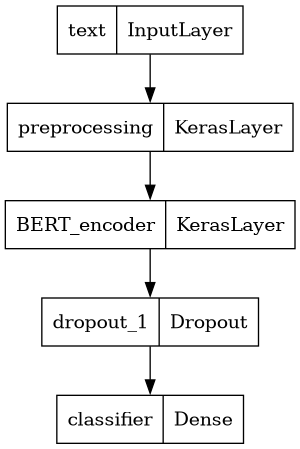

In [19]:
tf.keras.utils.plot_model(classifier_model)

In [20]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [21]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [22]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [23]:
history = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs, 
                               class_weight=class_weight_dict)

Epoch 1/10
57/57 [==============================] - 22s 251ms/step - loss: 0.6708 - binary_accuracy: 0.4936 - val_loss: 0.5068 - val_binary_accuracy: 0.6411
Epoch 2/10
57/57 [==============================] - 14s 242ms/step - loss: 0.5699 - binary_accuracy: 0.6369 - val_loss: 0.4178 - val_binary_accuracy: 0.7247
Epoch 3/10
57/57 [==============================] - 14s 245ms/step - loss: 0.4597 - binary_accuracy: 0.7535 - val_loss: 0.2951 - val_binary_accuracy: 0.8397
Epoch 4/10
57/57 [==============================] - 14s 241ms/step - loss: 0.3556 - binary_accuracy: 0.8345 - val_loss: 0.2078 - val_binary_accuracy: 0.9111
Epoch 5/10
57/57 [==============================] - 14s 243ms/step - loss: 0.2989 - binary_accuracy: 0.8845 - val_loss: 0.1793 - val_binary_accuracy: 0.9251
Epoch 6/10
57/57 [==============================] - 14s 242ms/step - loss: 0.2772 - binary_accuracy: 0.9023 - val_loss: 0.1847 - val_binary_accuracy: 0.9355
Epoch 7/10
57/57 [==============================] - 15s 25

18/18 [==============================] - 2s 99ms/step - loss: 0.3122 - binary_accuracy: 0.8815
Loss: 0.3122, Accuracy: 0.8815
18/18 [==============================] - 2s 93ms/step
Accuracy: 0.8954703832752613
Precision: 0.9757575757575757
Recall: 0.9096045197740112
F1-score: 0.9415204678362573


/tmp/ipykernel_137/127729454.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs_range, loss_values, 'b', label='Training loss', color='green')


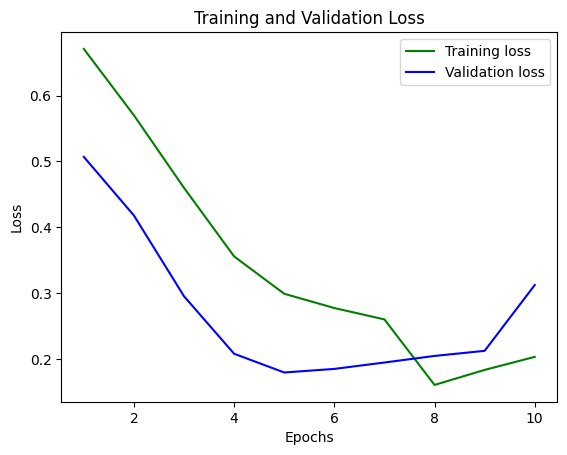

/tmp/ipykernel_137/127729454.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs_range, acc_values, 'b', label='Training acc', color='green')


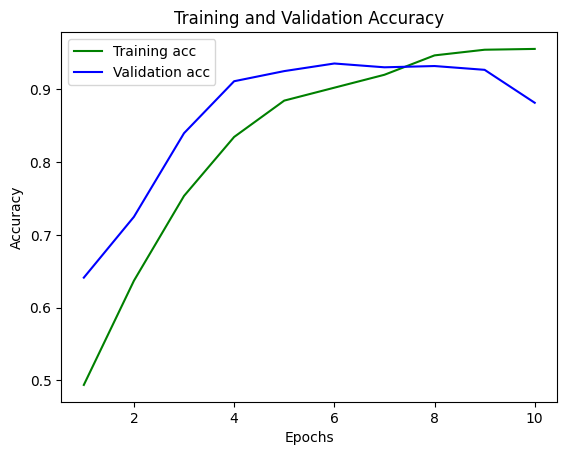

In [24]:
# Evaluation
results = classifier_model.evaluate(test_ds)
print(f"Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}")

# You can get more detailed metrics using predict:
predictions = classifier_model.predict(test_ds)
# Apply sigmoid to get probabilities
predicted_probabilities = tf.sigmoid(predictions) 

# Threshold the probabilities if needed (e.g., for binary classification)
threshold = 0.5
predicted_classes = tf.where(predicted_probabilities > threshold, 1, 0)

# ... Now you can use metrics from tf.keras.metrics or sklearn.metrics:
# Example using sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(test_df['target'].values, predicted_classes))
print("Precision:", precision_score(test_df['target'].values, predicted_classes))
print("Recall:", recall_score(test_df['target'].values, predicted_classes))
print("F1-score:", f1_score(test_df['target'].values, predicted_classes))

# Plotting the training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, loss_values, 'b', label='Training loss', color='green')
plt.plot(epochs_range, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs_range, acc_values, 'b', label='Training acc', color='green')
plt.plot(epochs_range, val_acc_values, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()